In [56]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import cv2

In [57]:
def resize_image(image):
    return cv2.resize(image, (450, 450))

In [58]:
# Function to overlay landmarks on the image
def overlay_landmarks(img, landmarks):
    # Reshape landmarks to separate x and y coordinates
    landmarks = landmarks.reshape(-1, 2)
    
    # Scale the landmarks back to the original image size
    landmarks[:, 0] *= img.shape[1] # The x-coordinates are multiplied by the width of the image
    landmarks[:, 1] *= img.shape[0] # The y-coordinates are multiplied by the height of the image
    
    # Draw landmarks on the image
    for landmark in landmarks:
        # the image , the center of the circle based on the landmarks coordinates , the radius , the color , fill the circle completely (no outline).
        cv2.circle(img, (int(landmark[0]), int(landmark[1])), 2, (0, 255, 0), -1)  # Draw a green circle

    return img

In [59]:
# Load the AFLW2K dataset
ds = tfds.load('aflw2k3d', split='train')

for ex in ds.take(4):
    print(ex['image'])

# Here we will split the image data and its corresponding 2D landmark coordinates.
images = []
landmarks2D = []

for ex in ds.take(2000):
    # extracts the image data from the current ex
    images.append(ex['image'])
    # extracts the 2D landmark coordinates
    landmarks2D.append(ex['landmarks_68_3d_xy_normalized'])

# convert the lists to numpy arrays
images = np.array(images)
landmarks2D = np.array(landmarks2D)

# print the length of the image array 
print (len(images))
# print the shape of the 2D landmark coordinates
print (landmarks2D[1].shape)

tf.Tensor(
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], shape=(450, 450, 3), dtype=uint8)
tf.Tensor(
[[[  9   0   0]
  [ 10   1   0]
  [ 13   4   0]
  ...
  [  4   5   0]
  [  5   5   0]
  [  5   5   0]]

 [[  9   0   0]
  [ 10   1   0]
  [ 14   5   0]
  ...
  [  4   5   0]
  [  4   4   0]
  [  4   4   0]]

 [[ 12   3   0]
  [ 13   5   0]
  [ 17   9   0]
  ...
  [  5   6   0]
  [  5   5   0]
  [  5   5   0]]

 ...

 [[190 157 114]
  [191 158 115]
  [186 154 113]
  ...
  [ 53  35  13]
  [ 55  37  13]
  [ 55  38  12]]

 [[194 163 117]
  [193 165 118]
  [188 161 118]
  ...
  [ 52  36  13]
  [ 53  37  12]
  [ 53  37  12]]

 [[

In [60]:
# Split the dataset into training and testing sets

# Shuffle indices
num_examples = len(images)
# create an array of integers ranging from 0 to num_examples to represent the indices of the data set
indices = np.arange(num_examples)
# shuffle these indices 
np.random.shuffle(indices)

# Define split sizes
train_size = 1500
# 2000-1500=500
test_size = num_examples - train_size 

print(train_size, "\n", test_size)

# Split indices: some for train data (1500) and some for test data(500)
train_indices = indices[:train_size]
test_indices = indices[train_size:]

# Split the dataset
train_images, test_images = images[train_indices], images[test_indices]

train_landmarks, test_landmarks = landmarks2D[train_indices], landmarks2D[test_indices]

1500 
 500


In [61]:
# Build the CNN model
# Define the model outside of a tf.function decorated function
model = tf.keras.Sequential([

    # Conv2D --> are used to extract features from the input images.
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    # 32 filters with size 3x3

    # tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(450, 450, 3)),

    # Max pooling reduces the spatial dimensions of the feature maps
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    # 64 filters with size 3x3

    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    # 128 filters with size 3x3

    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    # 128 filters with size 3x3

    tf.keras.layers.MaxPooling2D((2, 2)),

    # The Flatten layer converts the 2D feature maps into a 1D vector.
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512, activation='relu'),  #512 neurons
    tf.keras.layers.Dense(136, activation='relu'),  # Output layer for 68 landmarks (68 * 2 = 136)
])


In [62]:
# Compile the model
# Mean Squared Error = mse the loss function
# Mean Absolute Error = mae measures the average absolute difference between the predicted and actual values.

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
# The optimizer determines how the model’s weights are updated during training.(minimize the loss function)
# The loss function --> the difference between the predicted values and the actual values.
# metrics --> provide insights into the model’s performance.


In [63]:
# Reshape the target values to match the output shape of the model
train_landmarks_reshaped = train_landmarks.reshape(train_landmarks.shape[0], -1)

# train the model 
history = model.fit(train_images, train_landmarks_reshaped, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - loss: 97.3603 - mae: 1.8931 - val_loss: 0.3025 - val_mae: 0.5305
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step - loss: 0.3071 - mae: 0.5276 - val_loss: 0.2318 - val_mae: 0.4514
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step - loss: 0.2160 - mae: 0.4341 - val_loss: 0.1104 - val_mae: 0.2796
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step - loss: 0.0856 - mae: 0.2187 - val_loss: 0.0556 - val_mae: 0.1277
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - loss: 0.0547 - mae: 0.1242 - val_loss: 0.0530 - val_mae: 0.1160
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - loss: 0.0532 - mae: 0.1162 - val_loss: 0.0528 - val_mae: 0.1149
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - loss: 0.0532 - mae: 0.1160 - val_loss: 0.0528 - val_mae: 0.1146
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - loss: 0.0532 - mae: 0.1162 - val_loss: 0.0528 - val_mae: 0.1144
Epoch 9/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step - loss: 0.05

In [64]:
#the number of landmarks
num_landmarks = model.output_shape[1] // 2  # Divide by 2 because each landmark has x and y coordinates

In [65]:
# Get the lowest training loss from the history
lowest_loss = min(history.history['loss'])

In [66]:
# Reshape test_landmarks to match the output shape of the model
test_landmarks_reshaped = tmest_landmarks.reshape(test_landmarks.shape[0], -1)

# Evaluate the model
test_loss, test_mae = model.evaluate(test_images, test_landmarks_reshaped)

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 473ms/step - loss: 0.0531 - mae: 0.1164


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
[[0.         0.5027408 ]
 [0.34614813 0.5580073 ]
 [0.35076088 0.6131056 ]
 [0.36284655 0.6562118 ]
 [0.38242263 0.7056257 ]
 [0.         0.74597836]
 [0.42882144 0.77729267]
 [0.45981595 0.8056815 ]
 [0.5063522  0.81249404]
 [0.5627381  0.7962879 ]
 [0.59100574 0.        ]
 [0.61842656 0.        ]
 [0.6446812  0.7006819 ]
 [0.65902174 0.6513933 ]
 [0.         0.6046659 ]
 [0.         0.55082285]
 [0.68113154 0.49185413]
 [0.         0.45162883]
 [0.38546583 0.43465048]
 [0.40715492 0.43519056]
 [0.4326327  0.43593648]
 [0.45244664 0.44288197]
 [0.54432863 0.44261   ]
 [0.5656706  0.43298525]
 [0.59142005 0.42595667]
 [0.6169088  0.4282985 ]
 [0.6352765  0.4413607 ]
 [0.5018482  0.        ]
 [0.5003604  0.5340959 ]
 [0.49906313 0.56916815]
 [0.5018782  0.        ]
 [0.4744903  0.61997664]
 [0.48534912 0.6240959 ]
 [0.5041362  0.6237655 ]
 [0.         0.62088686]
 [0.         0.6185936 ]
 [0.39895126 0.49646333]
 [0.4125582  0.48064873]
 [0.43328166

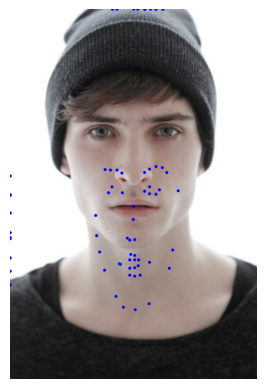

In [70]:
image = cv2.imread('man.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Resize the image to match the input size of the model (450x450)
resized_image = cv2.resize(image_rgb, (450, 450))

# Preprocess the image (normalize pixel values)
normalized_image = resized_image / 255.0

# Predict landmarks using the trained model
predicted_landmarks = model.predict(np.expand_dims(normalized_image, axis=0))

predicted_landmarks = predicted_landmarks.reshape(num_landmarks, 2)  # Reshape to (68, 2)
print(predicted_landmarks)

# Visualize the landmarks on the image
for x, y in predicted_landmarks:
    cv2.circle(image, (int(x * image.shape[1]), int(y * image.shape[0])), 3, (255, 0, 0), -1)

# Show the image with landmarks
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [68]:
print("Test Loss:", test_loss)
print("Test MAE:", test_mae)

Test Loss: 0.05303654819726944
Test MAE: 0.11636123061180115


In [69]:
# Print the number of landmarks and lowest loss
print("Number of landmarks:", num_landmarks)
print("Lowest training loss:", lowest_loss)

Number of landmarks: 68
Lowest training loss: 0.05306364223361015
